In [35]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime, timedelta

In [31]:
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [3]:
df = pd.read_csv("./Datasets/Formated-data.csv")

In [4]:
df.head()

,EmployeeCode,AppliedLeaveTypeName,LeaveDate,AppliedLeaveRemarks,DayName
0,6066,ANNUAL LEAVE,2024-07-31,Body pain,Wednesday
1,107,ANNUAL LEAVE,2024-02-01,From Transaction,Thursday
2,107,ANNUAL LEAVE,2024-02-02,From Transaction,Friday
3,107,ANNUAL LEAVE,2024-04-09,NaN,Tuesday
4,107,ANNUAL LEAVE,2024-06-18,leg pain,Tuesday


In [5]:
df.shape

(6471, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   EmployeeCode          6471 non-null   object
 1   AppliedLeaveTypeName  6471 non-null   object
 2   LeaveDate             6471 non-null   object
 3   AppliedLeaveRemarks   5862 non-null   object
 4   DayName               6471 non-null   object
dtypes: object(5)
memory usage: 252.9+ KB


In [7]:
df.isna().sum()

EmployeeCode              0
AppliedLeaveTypeName      0
LeaveDate                 0
AppliedLeaveRemarks     609
DayName                   0
dtype: int64

In [8]:
df['LeaveDate'] = pd.to_datetime(df['LeaveDate'], errors='coerce')

In [9]:
start_date = df['LeaveDate'].min()
end_date = df['LeaveDate'].max()

In [10]:
all_dates = pd.date_range(start=start_date, end=end_date)

In [11]:
all_dates_df = pd.DataFrame(all_dates, columns=['LeaveDate'])

In [12]:
employee_code = df['EmployeeCode'].iloc[1]  # Using the first employee code as the example
all_dates_df['EmployeeCode'] = employee_code

In [13]:
all_dates_df['DayName'] = all_dates_df['LeaveDate'].dt.day_name()

In [14]:
merged_df = pd.merge(all_dates_df, df[['EmployeeCode', 'LeaveDate', 'AppliedLeaveTypeName', 'AppliedLeaveRemarks']], 
                     on=['EmployeeCode', 'LeaveDate'], how='left')

In [15]:
merged_df['AppliedLeaveTypeName'].fillna(method='ffill', inplace=True)
merged_df['AppliedLeaveRemarks'].fillna(method='ffill', inplace=True)

C:\Users\mohan\AppData\Local\Temp\ipykernel_12628\3770438322.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['AppliedLeaveTypeName'].fillna(method='ffill', inplace=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_12628\3770438322.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['AppliedLeaveTypeName'].fillna(method='ffill', inplace=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_12628\3770438322.py:2: FutureWa

In [16]:
merged_df.head()

,LeaveDate,EmployeeCode,DayName,AppliedLeaveTypeName,AppliedLeaveRemarks
0,2024-02-01,107,Thursday,ANNUAL LEAVE,From Transaction
1,2024-02-02,107,Friday,ANNUAL LEAVE,From Transaction
2,2024-02-03,107,Saturday,ANNUAL LEAVE,From Transaction
3,2024-02-04,107,Sunday,ANNUAL LEAVE,From Transaction
4,2024-02-05,107,Monday,BACK TO INDIA,From Transaction


In [17]:
merged_df.fillna({
    'AppliedLeaveTypeName': "No Leave", 
    'AppliedLeaveRemarks': "No Remarks"
}, inplace=True)

In [18]:
merged_df['LeaveStatus'] = merged_df['AppliedLeaveTypeName'].apply(lambda x: 0 if (x == 'OFF IN LIEU' or x == 'ANNUAL LEAVE') else 1)

In [19]:
merged_df['AppliedLeaveTypeName'].unique()

array(['ANNUAL LEAVE', 'BACK TO INDIA'], dtype=object)

In [20]:
merged_df.shape

(182, 6)

In [21]:
data = merged_df.sort_values(by=['EmployeeCode', 'LeaveDate'])

In [22]:
data.set_index('LeaveDate', inplace=True)

In [23]:
data['AppliedLeaveTypeName'].unique()

array(['ANNUAL LEAVE', 'BACK TO INDIA'], dtype=object)

In [24]:
time_series = data['LeaveStatus']

In [25]:
time_series.unique()

array([0, 1], dtype=int64)

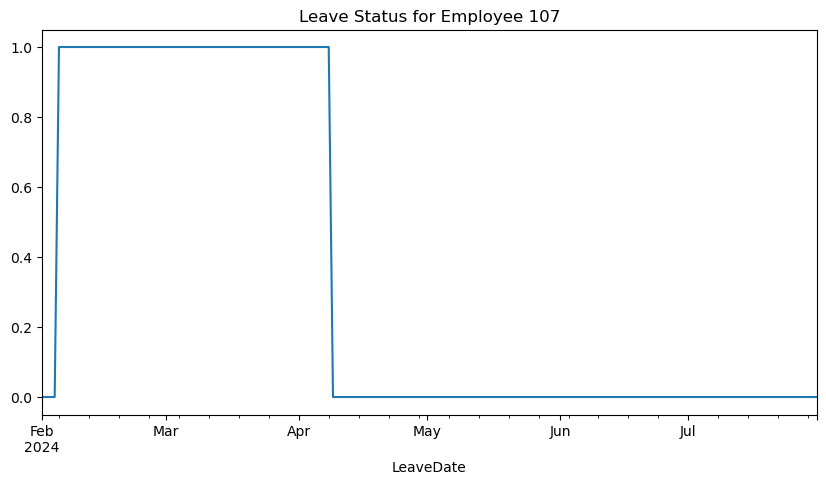

In [26]:
time_series.plot(title=f'Leave Status for Employee {employee_code}', figsize=(10, 5))
plt.show()

In [27]:
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Time series is NOT stationary. Consider differencing.")
    else:
        print("Time series is stationary.")


In [28]:
check_stationarity(time_series)

ADF Statistic: -1.4798180427591656
p-value: 0.543470396786865
Time series is NOT stationary. Consider differencing.


In [29]:
diff_series = time_series.diff().dropna()

In [30]:
check_stationarity(diff_series)

ADF Statistic: -13.341664064126334
p-value: 5.903464617998741e-25
Time series is stationary.


In [32]:
model = ARIMA(time_series, order=(2, 1, 0))  # Replace p, d, q with appropriate values
arima_result = model.fit()

d:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [33]:
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:            LeaveStatus   No. Observations:                  182
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 150.906
Date:                Sun, 22 Dec 2024   AIC                           -295.813
Time:                        19:42:53   BIC                           -286.217
Sample:                    02-01-2024   HQIC                          -291.922
                         - 07-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       8.255e-08    3.2e-13   2.58e+05      0.000    8.26e-08    8.26e-08
ar.L2       8.255e-08    3.2e-13   2.58e+05      0.000    8.26e-08    8.26e-08
sigma2         0.0110      0.000     63.645      0.0

In [34]:
# Forecast the next 7 days
forecast = arima_result.forecast(steps=7)
print(f"Forecasted Values: {forecast}")


Forecasted Values: 2024-08-01    0.0
2024-08-02    0.0
2024-08-03    0.0
2024-08-04    0.0
2024-08-05    0.0
2024-08-06    0.0
2024-08-07    0.0
Freq: D, Name: predicted_mean, dtype: float64


In [36]:
target_date = datetime(2024, 12, 25)  # Example: Christmas Day
current_date = time_series.index[-1]

In [37]:
steps_to_predict = (target_date - current_date).days

In [39]:
forecast = arima_result.forecast(steps=steps_to_predict)

In [41]:
predicted_value = forecast.iloc[-1]  # The last value corresponds to the target date
print(f"Predicted Value for {target_date}: {predicted_value}")

Predicted Value for 2024-12-25 00:00:00: 0.0
